# Library

In [2]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# GPU 용량 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 함수 모음

## RF_정확도(itemlist, name)

In [36]:
def RF_정확도(itemlist,name):

    # itemlist만을 가진 x_(7727,10)_itemlist 만들기
    item_list = list(total_data['ITEMID'].sort_values().unique())
    
    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,4068).npy')
    x_2d = x[:,item_index]
    x_2d
    
    np.save(f'x_(7727,10)_{name}.npy',x_2d)
    
    import random
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    model = RandomForestClassifier()

    data={}
    for seed in range(0, 50):
        random.seed(seed)
        
        x = np.load(f'./x_(7727,10)_{name}.npy')
        y = np.load('./y_(7727,1).npy')

        idx = list(range(len(x)))
        random.shuffle(idx)

        i = round(x.shape[0]*0.8)
        X_train, y_train = x[idx[:i],:], y[idx[:i]]
        X_test, y_test = x[idx[i:],:], y[idx[i:]]

        _ = model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred_test)
        data[seed]=acc
        print(f'정확도 : {acc}, seed_num = {seed}')

    df = pd.DataFrame.from_dict(data, orient='index')
    print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')    

## LSTM_정확도(itemlist, name)

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random

def LSTM_정확도(itemlist, name):

    # itemlist만을 가진 x_(7727,10,10)_itemlist 만들기
    total_data = pd.read_csv('total_data_7727.csv')
    item_list = list(total_data['ITEMID'].sort_values().unique())

    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,10,4068).npy')
    x_3d = x[:,:,item_index]
    
    np.save(f'x_(7727,10,10)_{name}.npy',x_3d)
    
    seed_num = 42
    random.seed(seed_num)
    
    x = np.load(f'x_(7727,10,10)_{name}.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

    # ---------------------
    seed_num = 42 
    # ---------------------
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/{name}'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + f'/{name}_seed42-'+'{epoch:02d}'+'-{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)
    
    with tf.device('/device:GPU:0'):
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

        from pathlib import Path
        paths = sorted(Path(MODEL_SAVE_FOLDER_PATH).iterdir(), key=os.path.getmtime)[-1]
        best_model_path = str(paths)

        from keras.models import load_model
        best_model = load_model(best_model_path) 

        dic_42={}
        for seed in range(0, 50):
            random.seed(seed)

            x = np.load(f'x_(7727,10,10)_{name}.npy')
            y = np.load('y_(7727,1).npy')

            idx = list(range(len(x)))
            random.shuffle(idx)

            i = round(x.shape[0]*0.8)
            X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
            X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

            pred = best_model.predict(X_test, batch_size=10000, workers=-1, use_multiprocessing=True)
            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            acc = metrics.accuracy_score(y_test, pred)
            dic_42[seed]=acc
            print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

        df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
        print(f'정확도 df 만들고 평균 확인 : {df_42.mean().values}')

## absum(item_list)
- 18에 비해서 hyperparameter 1개로 조정

In [28]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(itemlist):
    # 1) PRE_top10의 index 구하기
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in itemlist:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = itemlist

    # 생존한 4718명에 대한 비율 계산
    for i in itemlist:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = itemlist

    # 사망한 3009명에 대한 비율 계산
    for i in itemlist:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(itemlist): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

## violin_allfit(itemlist)

In [29]:
def violin_allfit(itemlist):
    
    # 1) DATA 
    x = np.load('/project/LSH/x_(7727,10,4068).npy')
    y = np.load('/project/LSH/y_(7727,1).npy')
    
    with tf.device('/device:GPU:0'):
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
        # 2) MODEL
        from keras.models import load_model
        lstm2 = load_model('./model/allfit2_seed42-06-0.5519.hdf5')

        _ = plt.figure(figsize = (13,12),dpi=150)

        for j, itemid in tqdm(enumerate(itemlist)):

            # 3) 환자별 base pred (Y')
            base_pred = pd.DataFrame(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

            total_data = pd.read_csv('total_data_7727.csv')
            features = total_data['ITEMID'].sort_values().unique()

            k = list(features).index(itemid)
            save_col = x[:,:,k].copy()

            # 4) 0 to 1
            x[:,:,k]= np.where(x[:,:,k]==0, 1, x[:,:,k])
            pred_0to1 = pd.DataFrame(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

            # 5) 1 to 0
            x[:,:,k] = np.where(x[:,:,k]==1, 0, x[:,:,k])
            pred_1to0 = pd.DataFrame(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

            # 6) inverse
            x[:,:,k] = save_col
            x[:,:,k] = np.where(x[:,:,k]==1, 2, x[:,:,k])
            x[:,:,k] = np.where(x[:,:,k]==0, 1, x[:,:,k])
            x[:,:,k] = np.where(x[:,:,k]==2, 0, x[:,:,k])
            pred_inverse = pd.DataFrame(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

            x[:,:,k] = save_col

            # 7) Merge & Visualize
            FI_merge_df = pd.concat([base_pred, pred_0to1, pred_1to0, pred_inverse], axis=1)
            FI_merge_df.columns = ['base_pred', 'pred_0to1', 'pred_1to0', 'pred_inverse']
            FI_merge_visual = FI_merge_df.melt(value_vars=['base_pred','pred_0to1','pred_1to0','pred_inverse'])
            FI_merge_visual.columns = ['method','pred_value']

            _ = plt.subplot(4,3,1+j)
            _ = plt.title(itemid)
            ax = sns.violinplot(data=FI_merge_visual, x='method',y='pred_value',
                                palette="Set2", inner="quartile")
    plt.tight_layout()

# 1️⃣ m1_allfit
- feature별 `E(0to1)-E(1to0)`이 담긴 df 생성

## LSTM / all fit / 약 2h 10m
- `LSH/model/allfit3_seed42-06-0.5525.hdf5`

In [3]:
# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/allfit3_seed42-06-0.5525.hdf5')

results = []
with tf.device('/device:GPU:0'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

100%|██████████| 4068/4068 [2:19:28<00:00,  2.06s/it]  


In [6]:
df = pd.DataFrame(results)
# df.to_csv('m1_allfit.csv',index = False)

## CuDNNLSTM / all fit / 약 2h 10m
- `LSH/model/CuDNNLSTM/4068_allfit_noearly-386-0.6526.hdf5`
- 예상과 달리 시간 단축이 안됨
- CuDNNLSTM이 LSTM에 비해 학습할 때는 속도가 3~4배 정도 빠른데 predict할 때는 속도가 비슷함

In [4]:
# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/CuDNNLSTM/4068_allfit_noearly-386-0.6526.hdf5')

results = []
with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)])
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

  2%|▏         | 94/4068 [03:09<2:13:51,  2.02s/it]


KeyboardInterrupt: 

## (66.6) LSTM 

In [13]:
m1_allfit = pd.read_csv('m1_allfit.csv')
m1_allfit = m1_allfit.sort_values(by='mean_diff', ascending=False)
m1_allfit_top10 = m1_allfit['feature'].values[:10]

In [22]:
LSTM_정확도(m1_allfit_top10,'m1_allfit_top10')

itemlist의 index :  [2195, 1081, 1276, 2148, 1011, 206, 1733, 3204, 3788, 3960]
Epoch 1/500
37/37 [==============================] - 6s 80ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66602, saving model to ./model/m1_allfit_top10/m1_allfit_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6732 - acc: 0.6068 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66602
Epoch 3/500
37/37 [==============================] - 3s 73ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66602 to 0.66549, saving model to ./model/m1_allfit_top10/m1_allfit_top10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 3s 71ms/step - loss: 0.6710 - acc: 0.6100 - val_loss: 0.6652 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66549 to 0.66520, saving model to ./

Epoch 30/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6009 - acc: 0.6557 - val_loss: 0.6015 - val_acc: 0.6643

Epoch 00030: val_loss improved from 0.60258 to 0.60153, saving model to ./model/m1_allfit_top10/m1_allfit_top10_seed42-30-0.6015.hdf5
Epoch 31/500
37/37 [==============================] - 3s 70ms/step - loss: 0.5969 - acc: 0.6639 - val_loss: 0.6016 - val_acc: 0.6630

Epoch 00031: val_loss did not improve from 0.60153
Epoch 32/500
37/37 [==============================] - 3s 70ms/step - loss: 0.5988 - acc: 0.6620 - val_loss: 0.6007 - val_acc: 0.6643

Epoch 00032: val_loss improved from 0.60153 to 0.60068, saving model to ./model/m1_allfit_top10/m1_allfit_top10_seed42-32-0.6007.hdf5
Epoch 33/500
37/37 [==============================] - 3s 71ms/step - loss: 0.5977 - acc: 0.6607 - val_loss: 0.6006 - val_acc: 0.6636

Epoch 00033: val_loss improved from 0.60068 to 0.60059, saving model to ./model/m1_allfit_top10/m1_allfit_top10_seed42-33-0.6006.hdf5
Epoch 34/50

## (66.2) RF

In [37]:
RF_정확도(m1_allfit_top10,'m1_allfit_top10')

itemlist의 index :  [2195, 1081, 1276, 2148, 1011, 206, 1733, 3204, 3788, 3960]
정확도 : 0.6459546925566343, seed_num = 0
정확도 : 0.6699029126213593, seed_num = 1
정확도 : 0.6634304207119741, seed_num = 2
정확도 : 0.6802588996763754, seed_num = 3
정확도 : 0.683495145631068, seed_num = 4
정확도 : 0.6763754045307443, seed_num = 5
정확도 : 0.6699029126213593, seed_num = 6
정확도 : 0.6679611650485436, seed_num = 7
정확도 : 0.6627831715210356, seed_num = 8
정확도 : 0.6627831715210356, seed_num = 9
정확도 : 0.6608414239482201, seed_num = 10
정확도 : 0.6595469255663431, seed_num = 11
정확도 : 0.6731391585760518, seed_num = 12
정확도 : 0.6524271844660194, seed_num = 13
정확도 : 0.6634304207119741, seed_num = 14
정확도 : 0.655663430420712, seed_num = 15
정확도 : 0.6588996763754046, seed_num = 16
정확도 : 0.6517799352750809, seed_num = 17
정확도 : 0.6614886731391586, seed_num = 18
정확도 : 0.6699029126213593, seed_num = 19
정확도 : 0.6601941747572816, seed_num = 20
정확도 : 0.6517799352750809, seed_num = 21
정확도 : 0.6653721682847896, seed_num = 22
정확도 : 0.64012

## absum 그래프

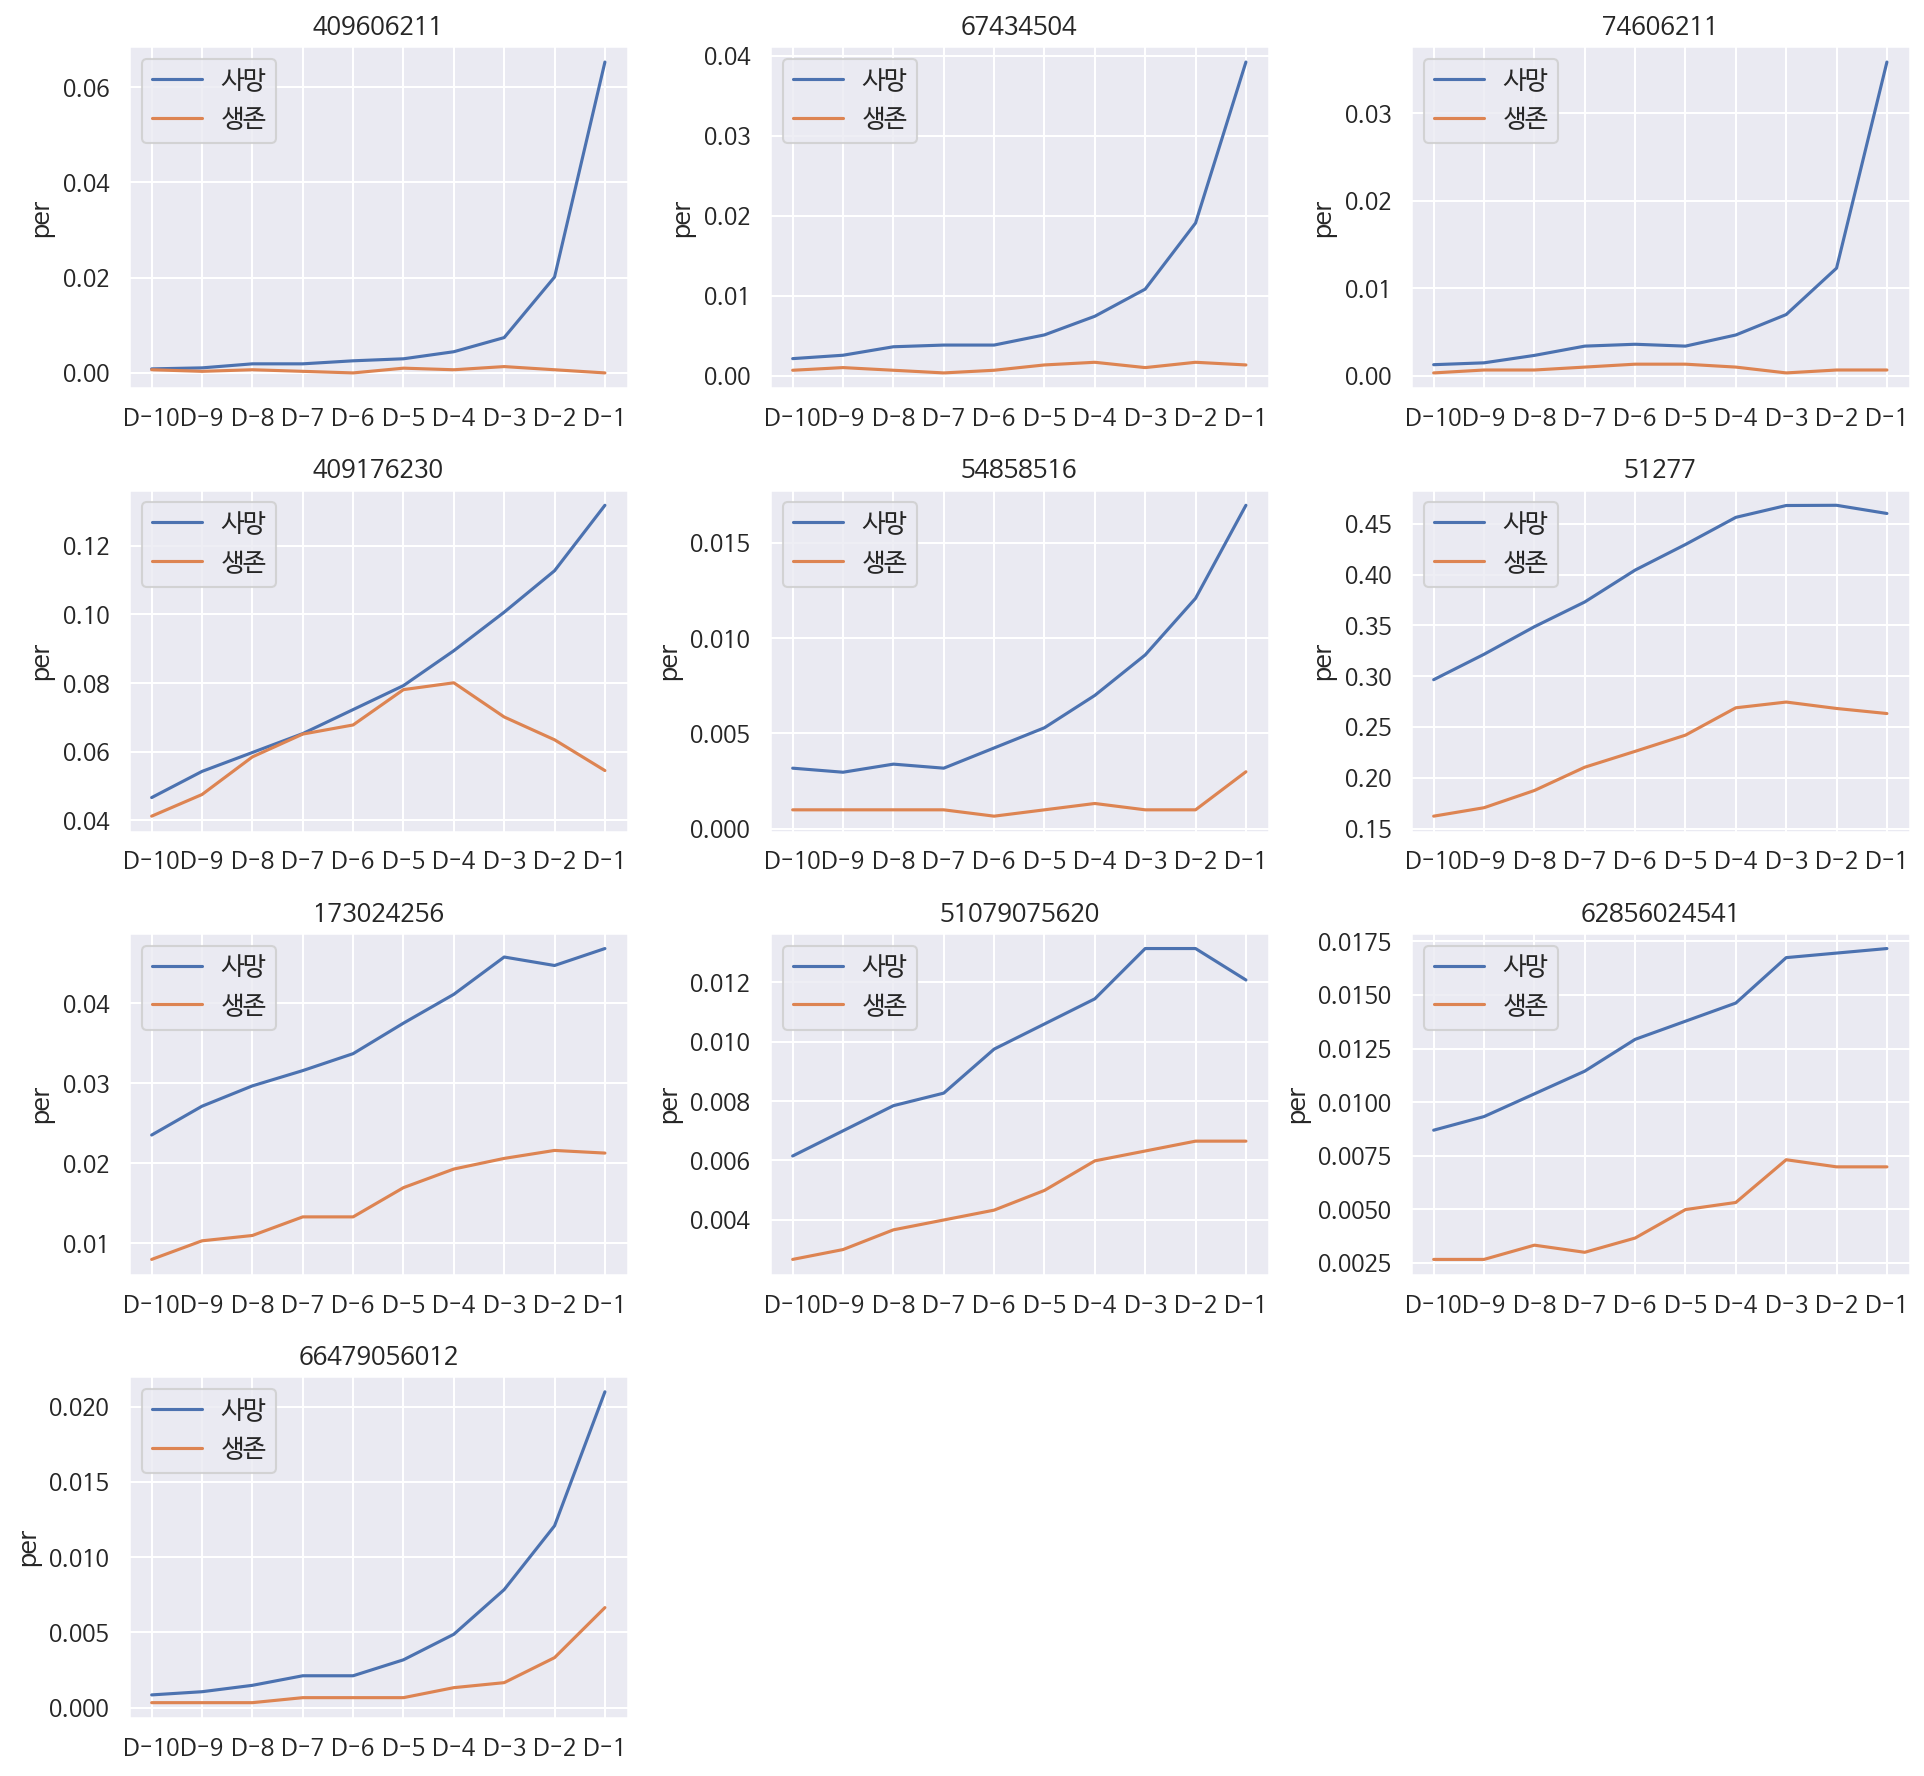

In [24]:
absum(m1_allfit_top10)

## violin plot

10it [01:23,  8.32s/it]


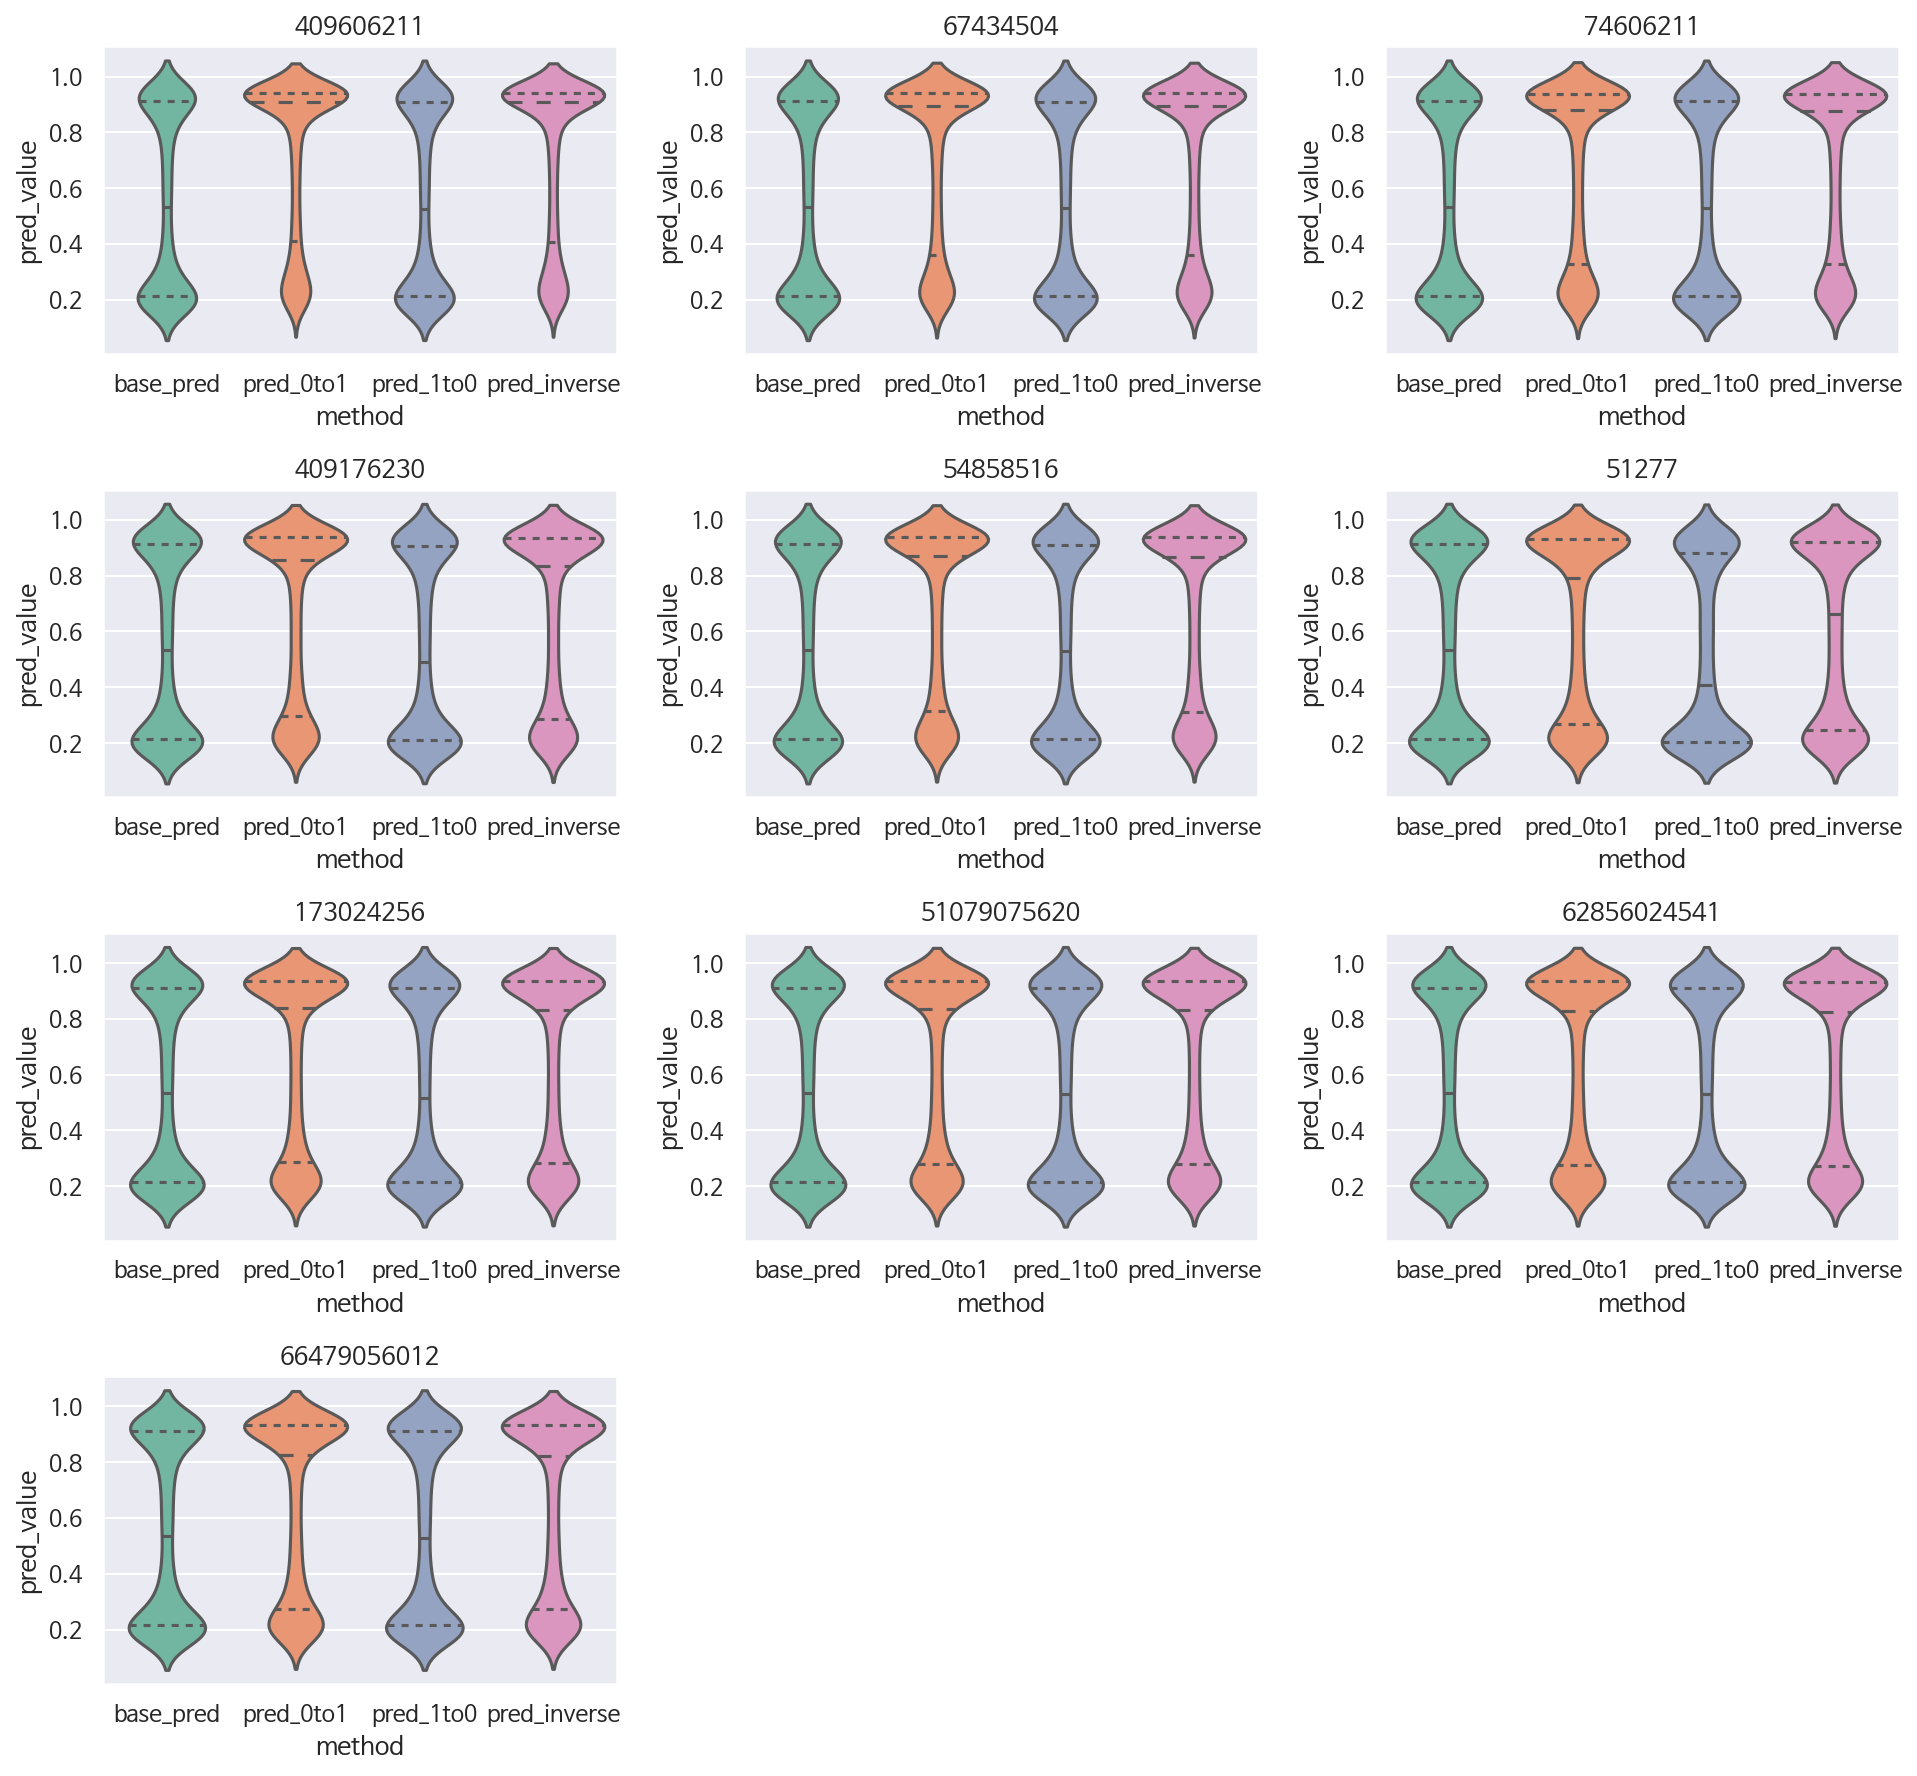

In [30]:
violin_allfit(m1_allfit_top10)

# 2️⃣ m1_allfit_entropy

In [31]:
entropy = pd.read_csv('m1_entropy.csv')
entropy = entropy.sort_values(by='feature')
entropy.index = range(4068)

m1_allfit = pd.read_csv('m1_allfit.csv')
m1_allfit_entropy = m1_allfit.copy()
m1_allfit_entropy['diff*entropy'] = entropy['entropy'] * m1_allfit['mean_diff']
m1_allfit_entropy = m1_allfit_entropy.sort_values(by='diff*entropy', ascending=False)
m1_allfit_entropy
# m1_allfit_entropy.to_csv('m1_allfit_entropy.csv', index=False)

,feature,mean_diff,diff*entropy
206,51277,0.116958,0.107523
121,51006,0.086929,0.085272
56,50912,0.068324,0.057957
2148,409176230,0.119119,0.045340
34,50882,0.057849,0.044414
...,...,...,...
187,51249,-0.058820,-0.032506
0,0,-0.038682,-0.034603
619,8084199,-0.060372,-0.036869
19,50861,-0.100435,-0.040175


In [33]:
# m1_allfit_entropy_top10
m1_allfit_entropy = pd.read_csv('m1_allfit_entropy.csv')
m1_allfit_entropy_top10 = m1_allfit_entropy['feature'].values[:10]

## (70.1) LSTM

In [34]:
LSTM_정확도(m1_allfit_entropy_top10,'m1_allfit_entropy_top10')

itemlist의 index :  [206, 121, 56, 2148, 34, 41, 103, 119, 20, 203]
Epoch 1/500
37/37 [==============================] - 6s 81ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66597, saving model to ./model/m1_allfit_entropy_top10/m1_allfit_entropy_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6731 - acc: 0.6068 - val_loss: 0.6661 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66597
Epoch 3/500
37/37 [==============================] - 3s 69ms/step - loss: 0.6734 - acc: 0.6083 - val_loss: 0.6645 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66597 to 0.66453, saving model to ./model/m1_allfit_entropy_top10/m1_allfit_entropy_top10_seed42-03-0.6645.hdf5
Epoch 4/500
37/37 [==============================] - 3s 69ms/step - loss: 0.6636 - acc: 0.6119 - val_loss: 0.6472 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66453 to 0.64724

37/37 [==============================] - 3s 70ms/step - loss: 0.5649 - acc: 0.7110 - val_loss: 0.5860 - val_acc: 0.6895

Epoch 00066: val_loss did not improve from 0.58580
Epoch 67/500
37/37 [==============================] - 3s 73ms/step - loss: 0.5636 - acc: 0.7129 - val_loss: 0.5871 - val_acc: 0.6953

Epoch 00067: val_loss did not improve from 0.58580
Epoch 68/500
37/37 [==============================] - 3s 70ms/step - loss: 0.5655 - acc: 0.7114 - val_loss: 0.5869 - val_acc: 0.6928

Epoch 00068: val_loss did not improve from 0.58580
Epoch 69/500
37/37 [==============================] - 3s 72ms/step - loss: 0.5647 - acc: 0.7148 - val_loss: 0.5864 - val_acc: 0.6921

Epoch 00069: val_loss did not improve from 0.58580
Epoch 70/500
37/37 [==============================] - 3s 71ms/step - loss: 0.5659 - acc: 0.7118 - val_loss: 0.5865 - val_acc: 0.6908

Epoch 00070: val_loss did not improve from 0.58580
Epoch 71/500
37/37 [==============================] - 3s 69ms/step - loss: 0.5609 - acc:

## (65.1) RF

In [38]:
RF_정확도(m1_allfit_entropy_top10,'m1_allfit_entropy_top10')

itemlist의 index :  [206, 121, 56, 2148, 34, 41, 103, 119, 20, 203]
정확도 : 0.6388349514563106, seed_num = 0
정확도 : 0.6407766990291263, seed_num = 1
정확도 : 0.6446601941747573, seed_num = 2
정확도 : 0.6420711974110033, seed_num = 3
정확도 : 0.654368932038835, seed_num = 4
정확도 : 0.6563106796116505, seed_num = 5
정확도 : 0.6453074433656958, seed_num = 6
정확도 : 0.6485436893203883, seed_num = 7
정확도 : 0.6601941747572816, seed_num = 8
정확도 : 0.6414239482200648, seed_num = 9
정확도 : 0.6504854368932039, seed_num = 10
정확도 : 0.6498381877022654, seed_num = 11
정확도 : 0.6679611650485436, seed_num = 12
정확도 : 0.655663430420712, seed_num = 13
정확도 : 0.6517799352750809, seed_num = 14
정확도 : 0.6588996763754046, seed_num = 15
정확도 : 0.6796116504854369, seed_num = 16
정확도 : 0.6414239482200648, seed_num = 17
정확도 : 0.6576051779935275, seed_num = 18
정확도 : 0.6537216828478964, seed_num = 19
정확도 : 0.6381877022653721, seed_num = 20
정확도 : 0.6550161812297735, seed_num = 21
정확도 : 0.6388349514563106, seed_num = 22
정확도 : 0.6297734627831715,

## absum 그래프

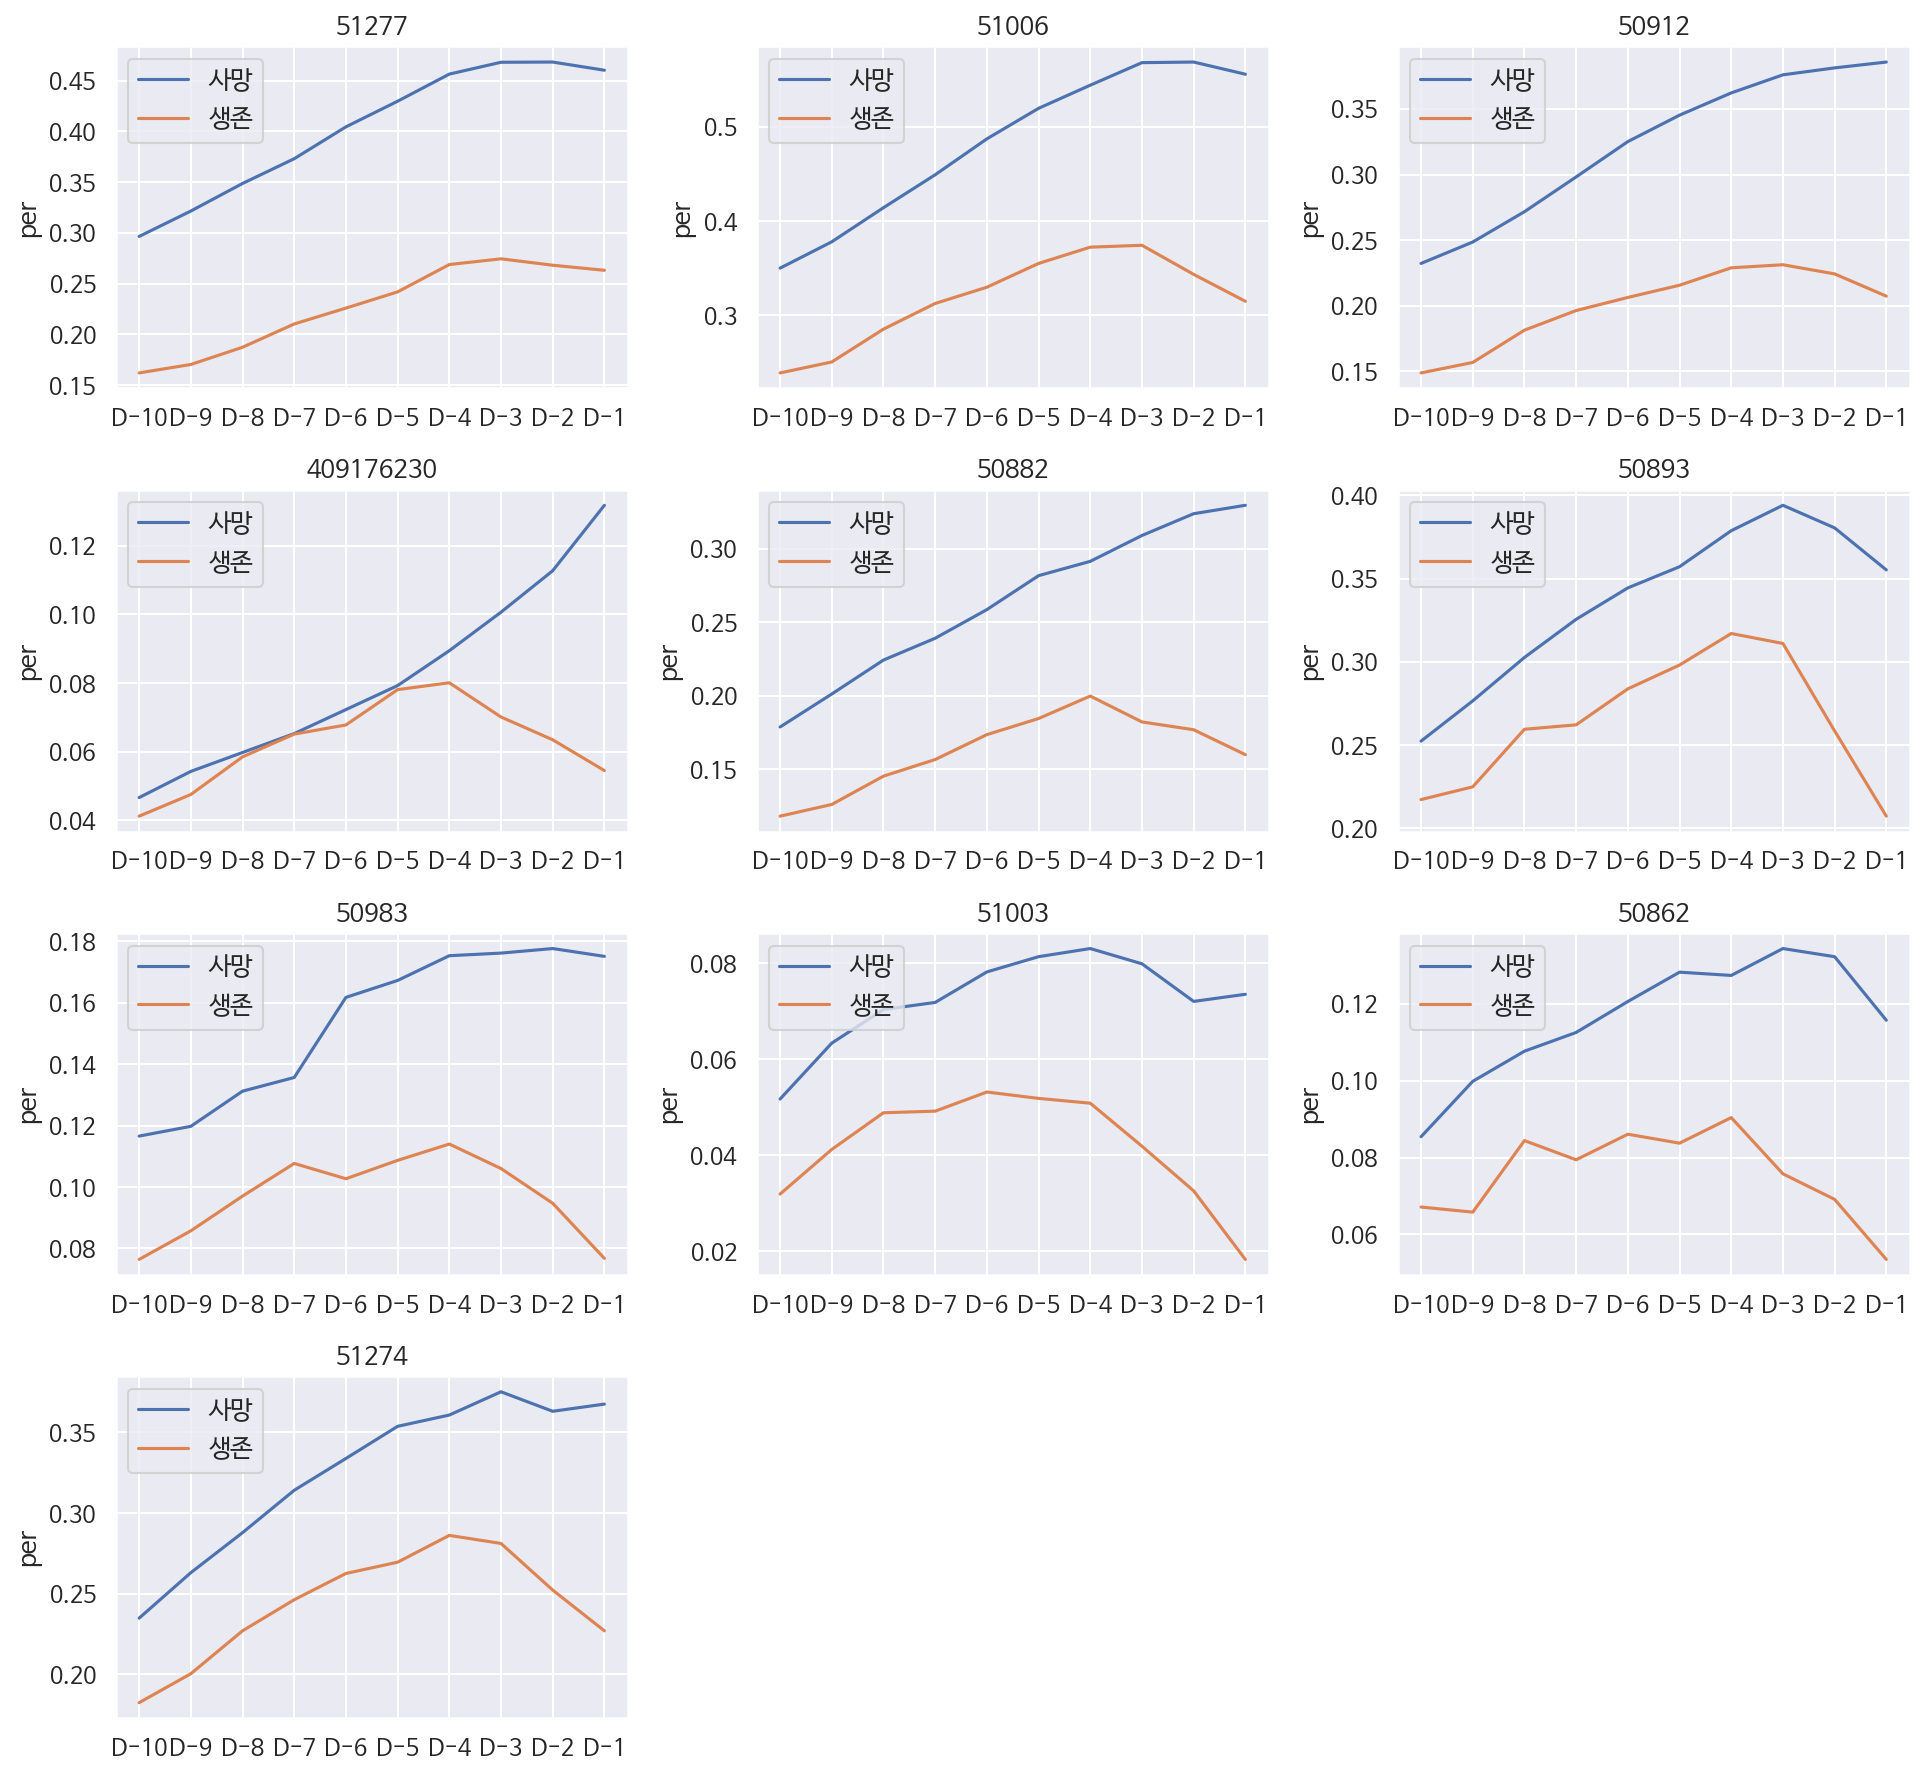

In [39]:
absum(m1_allfit_entropy_top10)

## violin plot

10it [01:18,  7.87s/it]


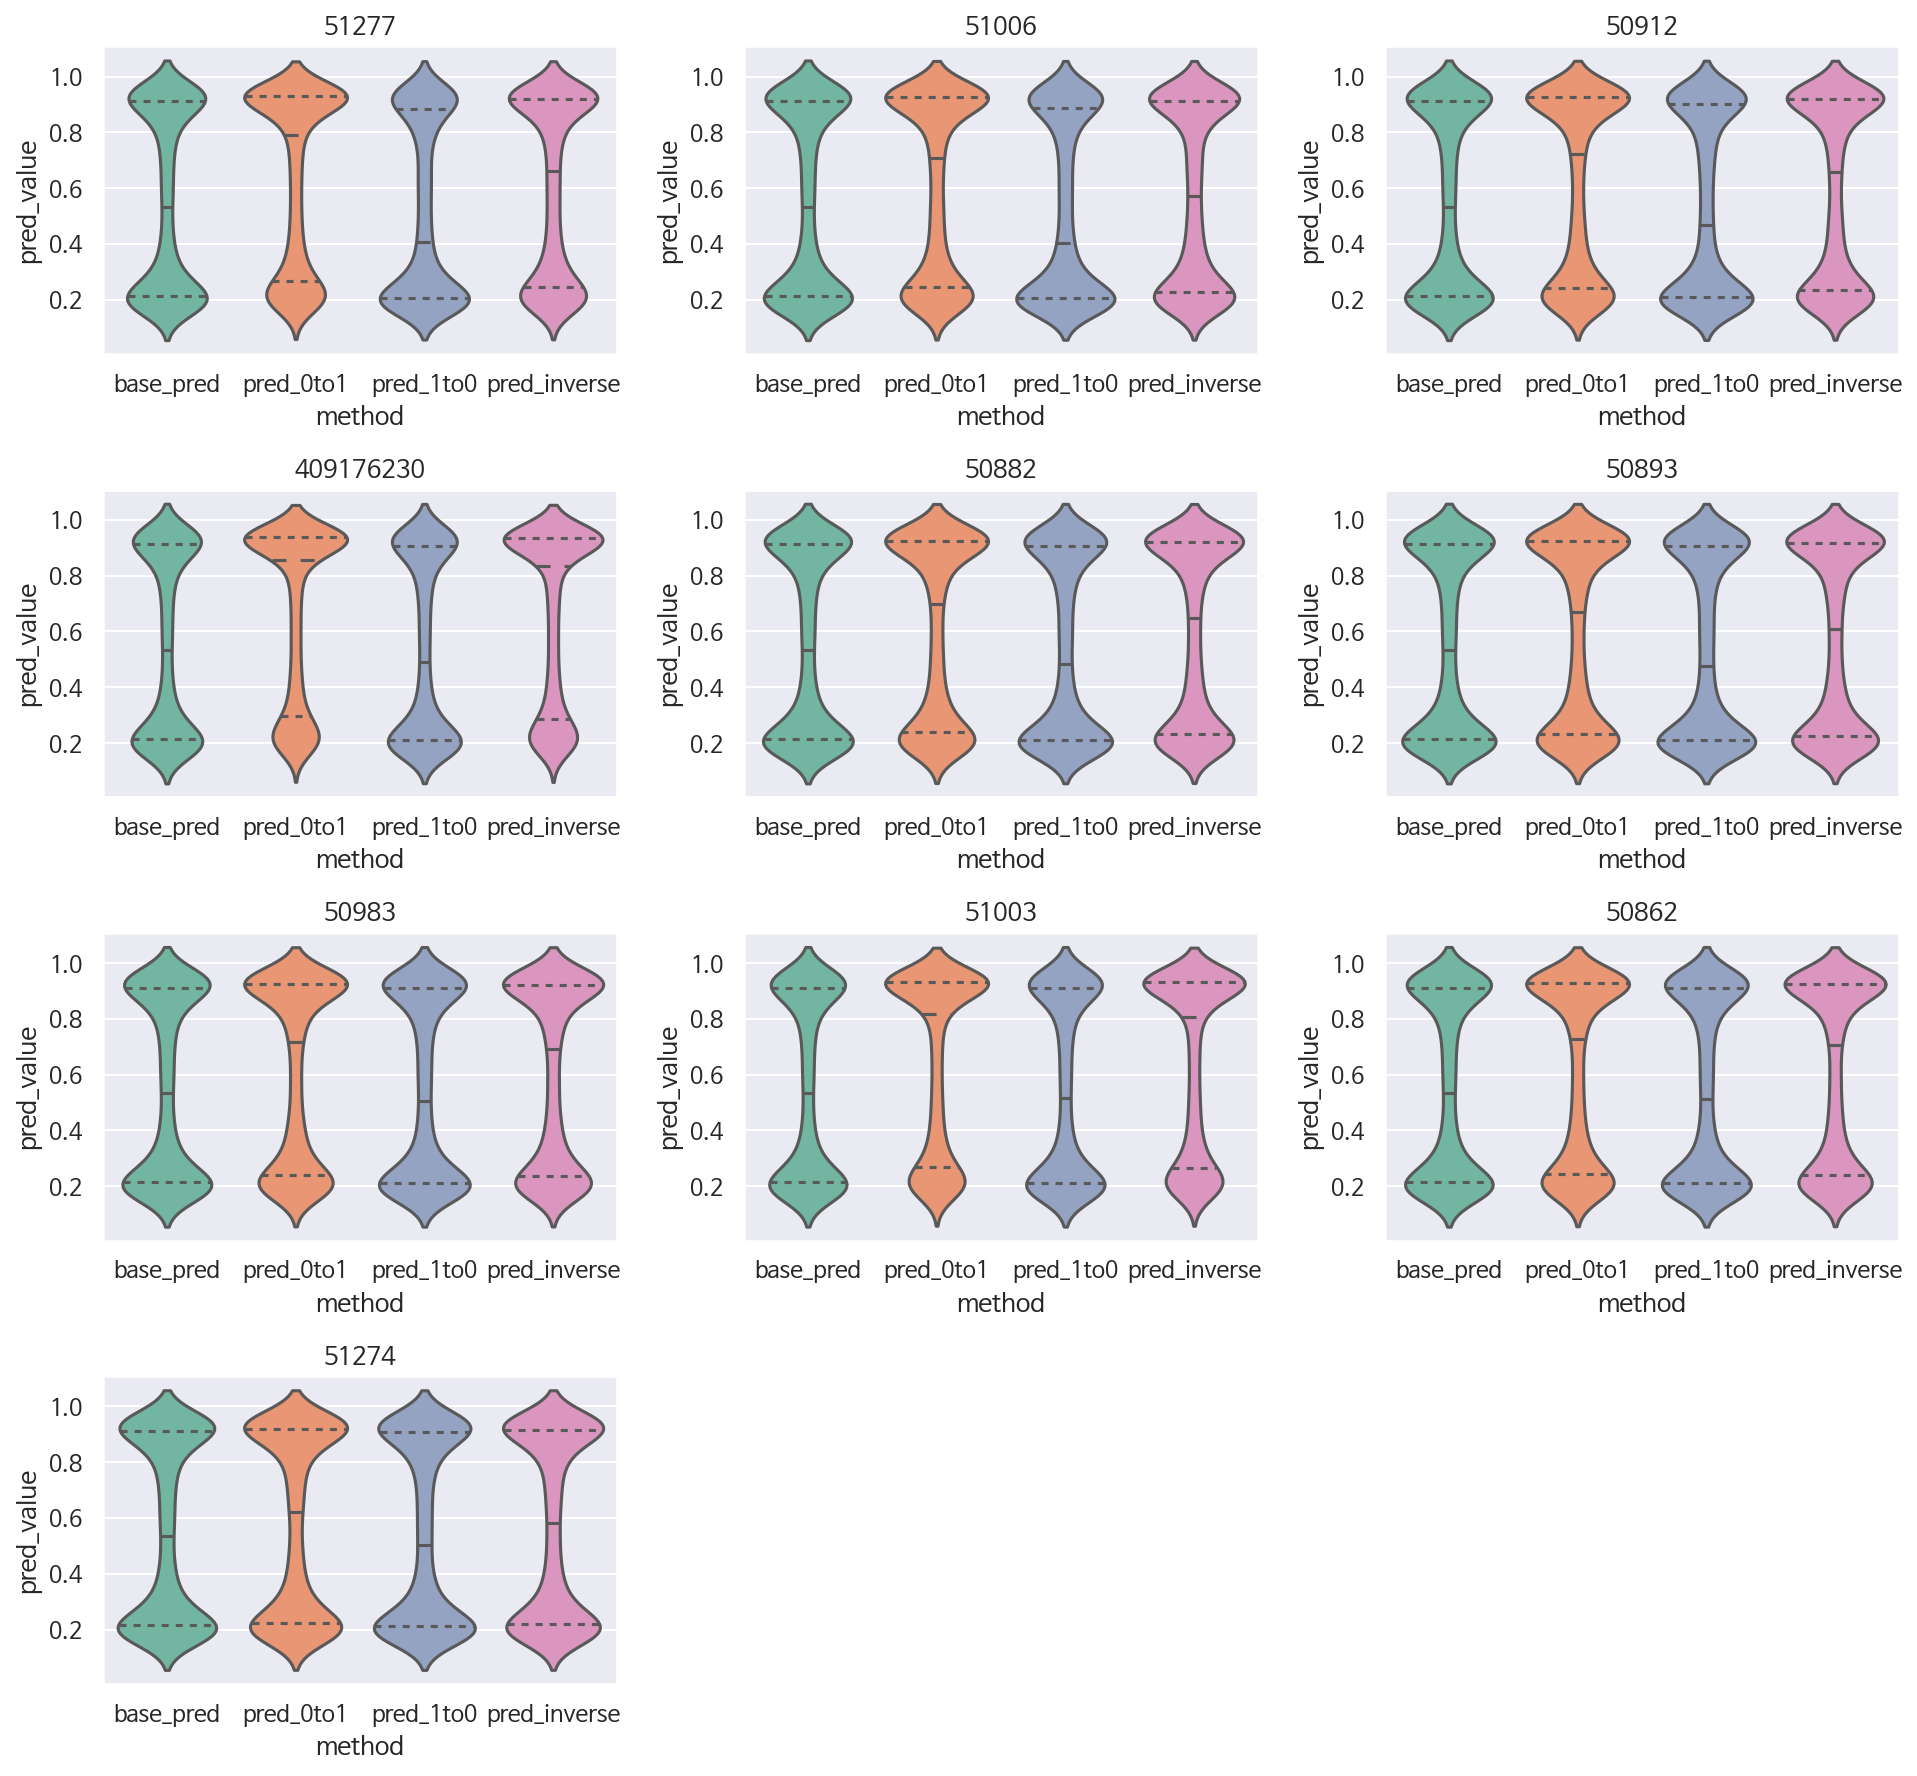

In [40]:
violin_allfit(m1_allfit_entropy_top10)

# 3️⃣ m1_sequential

## code test - df_2

In [5]:
# 1st top1 : 409606211

m1_allfit = pd.read_csv('m1_allfit.csv')
m1_allfit = m1_allfit.sort_values(by='mean_diff', ascending=False)
m1_allfit

top1_1 = m1_allfit['feature'].values[0]
top1_1

,feature,mean_diff
2195,409606211,0.163214
1081,67434504,0.143361
1276,74606211,0.126000
2148,409176230,0.119119
1011,54858516,0.118077
...,...,...
3113,51079028520,-0.079562
2106,406051262,-0.083803
2824,17714002001,-0.086603
469,4003822,-0.091247


409606211

In [9]:
# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

total_data = pd.read_csv('total_data_7727.csv')
features = list(total_data['ITEMID'].sort_values().unique())

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

# ----------- top1_1의 index ----------------------
m1_allfit = pd.read_csv('m1_allfit.csv')
m1_allfit = m1_allfit.sort_values(by='mean_diff', ascending=False)
top1_1 = m1_allfit['feature'].values[0]
top1_1_idx = features.index(top1_1)

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/allfit3_seed42-06-0.5525.hdf5')

results = []
with tf.device('/device:GPU:0'):

    for i in tqdm(range(len(features))):

        save_col = x[:,:,[i,top1_1_idx]].copy()

        # 3) E(0to1)
        x[:,:,[i,top1_1_idx]] = 1
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,[i,top1_1_idx]] = 0
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,[i,top1_1_idx]] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

Using TensorFlow backend.


  5%|▌         | 214/4068 [06:26<1:56:01,  1.81s/it]


KeyboardInterrupt: 

In [ ]:
df_2 = pd.DataFrame(results)
df_2 = df_2.sort_values(by='mean_diff', ascending=False)
df_2
# df_2.to_csv('df_2.csv', index=False)

In [52]:
df_2_test = pd.read_csv('df_2.csv')
df_2_test

,feature,mean_diff
0,67434504,0.279540
1,51277,0.270293
2,74606211,0.266377
3,409176230,0.264936
4,54858516,0.260672
...,...,...
4063,63323038810,0.086737
4064,406051262,0.082551
4065,17714002001,0.079593
4066,4003822,0.074138


## code test - feature n개
- feature n개로 지정해서 df_2 ~ df_10의 top1_features 확인
- n : 10, 20, 100

In [49]:
# test
from tqdm.notebook import tqdm

# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

total_data = pd.read_csv('total_data_7727.csv')
features = list(total_data['ITEMID'].sort_values().unique())

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

# ----------- top1_1의 index ----------------------
top1_1 = 0
top1_1_idx = features.index(top1_1)
# -------------------------------------------------

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/allfit3_seed42-06-0.5525.hdf5')

top1_features = []

with tf.device('/device:GPU:0'):
    for j in tqdm(range(2,11)):
        results = []
        if j == 2: # top1_1을 아는 상태 -> top1_2를 구해야함 
            for i in tqdm(range(len(features[:100]))):

                save_col = x[:,:,[i,top1_1_idx]].copy()

                # 3) E(0to1)
                x[:,:,[i,top1_1_idx]] = 1
                pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                # 4) E(1to0)
                x[:,:,[i,top1_1_idx]] = 0
                pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                x[:,:,[i,top1_1_idx]] = save_col

                # 5) Merge
                mean_diff = pred_0to1 - pred_1to0
                results.append({'feature':features[i],'mean_diff':mean_diff})
            globals()[f'df_{j}'] = pd.DataFrame(results) # df_2 정의 
            globals()[f'df_{j}'] = globals()[f'df_{j}'].sort_values(by='mean_diff', ascending=False)
            globals()[f'top1_{j}'] = globals()[f'df_{j}']['feature'].values[0]
            top1_features.append(globals()[f'top1_{j}'])
        else:
            globals()[f'top1_{j}_idx'] = features.index(top1_features[-1])
            
            for i in tqdm(range(len(features[:100]))):
                
                save_col = x[:,:,[i,globals()[f'top1_{j}_idx']]].copy()

                # 3) E(0to1)
                x[:,:,[i,globals()[f'top1_{j}_idx']]] = 1
                pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                # 4) E(1to0)
                x[:,:,[i,globals()[f'top1_{j}_idx']]] = 0
                pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                x[:,:,[i,globals()[f'top1_{j}_idx']]] = save_col

                # 5) Merge
                mean_diff = pred_0to1 - pred_1to0
                results.append({'feature':features[i],'mean_diff':mean_diff})
            globals()[f'df_{j}'] = pd.DataFrame(results) # df_3, df_4, ..., df_10정의  
            globals()[f'df_{j}'] = globals()[f'df_{j}'].sort_values(by='mean_diff', ascending=False)
            globals()[f'top1_{j}'] = globals()[f'df_{j}']['feature'].values[0]
            top1_features.append(globals()[f'top1_{j}'])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
# feature[:100]
top1_features

[50912, 50868, 50912, 50868, 50912, 50868, 50912, 50868, 50912]

In [51]:
# feature[:100]
df_3.head(3)['feature'].values
df_4.head(3)['feature'].values
df_5.head(3)['feature'].values

df_3.tail(3)['feature'].values
df_4.tail(3)['feature'].values
df_5.tail(3)['feature'].values

array([50868, 50813, 50882])

array([50912, 50813, 50882])

array([50868, 50813, 50882])

array([50922, 50924, 50861])

array([50922, 50924, 50861])

array([50922, 50924, 50861])

In [47]:
# feature[:20]
top1_features

[50813, 50809, 50813, 50809, 50813, 50809, 50813, 50809, 50813]

In [45]:
# feature[:20]
df_3.head(3)['feature'].values
df_4.head(3)['feature'].values
df_5.head(3)['feature'].values

df_3.tail(3)['feature'].values
df_4.tail(3)['feature'].values
df_5.tail(3)['feature'].values

array([50809, 50820, 50806])

array([50813, 50820, 50806])

array([50809, 50820, 50806])

array([    0, 50856, 50861])

array([    0, 50856, 50861])

array([    0, 50856, 50861])

In [46]:
# feature[:10]
df_3.head(3)['feature'].values
df_4.head(3)['feature'].values
df_5.head(3)['feature'].values

df_3.tail(3)['feature'].values
df_4.tail(3)['feature'].values
df_5.tail(3)['feature'].values

array([50809, 50820, 50806])

array([50813, 50820, 50806])

array([50809, 50820, 50806])

array([    0, 50856, 50861])

array([    0, 50856, 50861])

array([    0, 50856, 50861])

## 본 코드

In [12]:
from tqdm.notebook import tqdm

# 1) DATA 
import random    
seed_num = 42
random.seed(seed_num)

total_data = pd.read_csv('total_data_7727.csv')
features = list(total_data['ITEMID'].sort_values().unique())

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

# ----------- top1_1의 index ----------------------
m1_allfit = pd.read_csv('m1_allfit.csv')
m1_allfit = m1_allfit.sort_values(by='mean_diff', ascending=False)
top1_1 = m1_allfit['feature'].values[0]
top1_1_idx = features.index(top1_1)

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/allfit3_seed42-06-0.5525.hdf5')

top1_features = []

with tf.device('/device:GPU:0'):
    for j in tqdm(range(2,11)):
        results = []
        if j == 2: # top1_1을 아는 상태 -> top1_2를 구해야함 
            for i in tqdm(range(len(features))):

                save_col = x[:,:,[i,top1_1_idx]].copy()

                # 3) E(0to1)
                x[:,:,[i,top1_1_idx]] = 1
                pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                # 4) E(1to0)
                x[:,:,[i,top1_1_idx]] = 0
                pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                x[:,:,[i,top1_1_idx]] = save_col

                # 5) Merge
                mean_diff = pred_0to1 - pred_1to0
                results.append({'feature':features[i],'mean_diff':mean_diff})
            globals()[f'df_{j}'] = pd.DataFrame(results) # df_2 정의 
            globals()[f'df_{j}'] = globals()[f'df_{j}'].sort_values(by='mean_diff', ascending=False)
            globals()[f'top1_{j}'] = globals()[f'df_{j}']['feature'].values[0]
            top1_features.append(globals()[f'top1_{j}'])
        else:
            globals()[f'top1_{j}_idx'] = features.index(top1_features[-1])
            
            for i in tqdm(range(len(features))):
                
                save_col = x[:,:,[i,globals()[f'top1_{j}_idx']]].copy()

                # 3) E(0to1)
                x[:,:,[i,globals()[f'top1_{j}_idx']]] = 1
                pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                # 4) E(1to0)
                x[:,:,[i,globals()[f'top1_{j}_idx']]] = 0
                pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

                x[:,:,[i,globals()[f'top1_{j}_idx']]] = save_col

                # 5) Merge
                mean_diff = pred_0to1 - pred_1to0
                results.append({'feature':features[i],'mean_diff':mean_diff})
            globals()[f'df_{j}'] = pd.DataFrame(results) # df_3, df_4, ..., df_10정의  
            globals()[f'df_{j}'] = globals()[f'df_{j}'].sort_values(by='mean_diff', ascending=False)
            globals()[f'top1_{j}'] = globals()[f'df_{j}']['feature'].values[0]
            top1_features.append(globals()[f'top1_{j}'])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4068 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 4️⃣ m1_sequential_entropy

# 5️⃣ RF_top10

In [43]:
rf_top10 = [51277, 50912, 51006, 63323026201, 50862, 50983, 51003, 51275, 904224461, 50882]

## (71.6) LSTM

In [44]:
LSTM_정확도(rf_top10,'rf_top10')

itemlist의 index :  [206, 56, 121, 3832, 20, 103, 119, 204, 2611, 34]
Epoch 1/500
37/37 [==============================] - 6s 75ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66595, saving model to ./model/rf_top10/rf_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6730 - acc: 0.6068 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66595
Epoch 3/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6731 - acc: 0.6087 - val_loss: 0.6631 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66595 to 0.66314, saving model to ./model/rf_top10/rf_top10_seed42-03-0.6631.hdf5
Epoch 4/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6546 - acc: 0.6156 - val_loss: 0.6224 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66314 to 0.62244, saving model to ./model/rf_top10/rf_top10_seed42-04-0.62

37/37 [==============================] - 2s 66ms/step - loss: 0.5649 - acc: 0.7097 - val_loss: 0.5687 - val_acc: 0.7012

Epoch 00036: val_loss improved from 0.56968 to 0.56867, saving model to ./model/rf_top10/rf_top10_seed42-36-0.5687.hdf5
Epoch 37/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5627 - acc: 0.7151 - val_loss: 0.5678 - val_acc: 0.7025

Epoch 00037: val_loss improved from 0.56867 to 0.56776, saving model to ./model/rf_top10/rf_top10_seed42-37-0.5678.hdf5
Epoch 38/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5620 - acc: 0.7140 - val_loss: 0.5675 - val_acc: 0.7038

Epoch 00038: val_loss improved from 0.56776 to 0.56755, saving model to ./model/rf_top10/rf_top10_seed42-38-0.5675.hdf5
Epoch 39/500
37/37 [==============================] - 2s 67ms/step - loss: 0.5628 - acc: 0.7118 - val_loss: 0.5660 - val_acc: 0.7018

Epoch 00039: val_loss improved from 0.56755 to 0.56600, saving model to ./model/rf_top10/rf_top10_seed42-39-0.5660.hd


Epoch 00075: val_loss did not improve from 0.56222
Epoch 76/500
37/37 [==============================] - 2s 66ms/step - loss: 0.5509 - acc: 0.7278 - val_loss: 0.5618 - val_acc: 0.7012

Epoch 00076: val_loss improved from 0.56222 to 0.56180, saving model to ./model/rf_top10/rf_top10_seed42-76-0.5618.hdf5
Epoch 77/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5478 - acc: 0.7222 - val_loss: 0.5624 - val_acc: 0.7018

Epoch 00077: val_loss did not improve from 0.56180
Epoch 78/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5509 - acc: 0.7217 - val_loss: 0.5624 - val_acc: 0.6999

Epoch 00078: val_loss did not improve from 0.56180
Epoch 79/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5494 - acc: 0.7230 - val_loss: 0.5625 - val_acc: 0.7012

Epoch 00079: val_loss did not improve from 0.56180
Epoch 80/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5490 - acc: 0.7252 - val_loss: 0.5626 - val_acc: 0.6992

Epoch

## (67.8) RF

In [45]:
RF_정확도(rf_top10,'rf_top10')

itemlist의 index :  [206, 56, 121, 3832, 20, 103, 119, 204, 2611, 34]
정확도 : 0.6666666666666666, seed_num = 0
정확도 : 0.6886731391585761, seed_num = 1
정확도 : 0.6789644012944984, seed_num = 2
정확도 : 0.6705501618122978, seed_num = 3
정확도 : 0.6621359223300971, seed_num = 4
정확도 : 0.6854368932038835, seed_num = 5
정확도 : 0.6763754045307443, seed_num = 6
정확도 : 0.6809061488673139, seed_num = 7
정확도 : 0.6964401294498382, seed_num = 8
정확도 : 0.6763754045307443, seed_num = 9
정확도 : 0.6880258899676376, seed_num = 10
정확도 : 0.6893203883495146, seed_num = 11
정확도 : 0.6841423948220064, seed_num = 12
정확도 : 0.6925566343042071, seed_num = 13
정확도 : 0.6750809061488673, seed_num = 14
정확도 : 0.6893203883495146, seed_num = 15
정확도 : 0.6880258899676376, seed_num = 16
정확도 : 0.6705501618122978, seed_num = 17
정확도 : 0.686084142394822, seed_num = 18
정확도 : 0.6757281553398058, seed_num = 19
정확도 : 0.6744336569579288, seed_num = 20
정확도 : 0.6925566343042071, seed_num = 21
정확도 : 0.6711974110032363, seed_num = 22
정확도 : 0.64271844660194

## absum 그래프

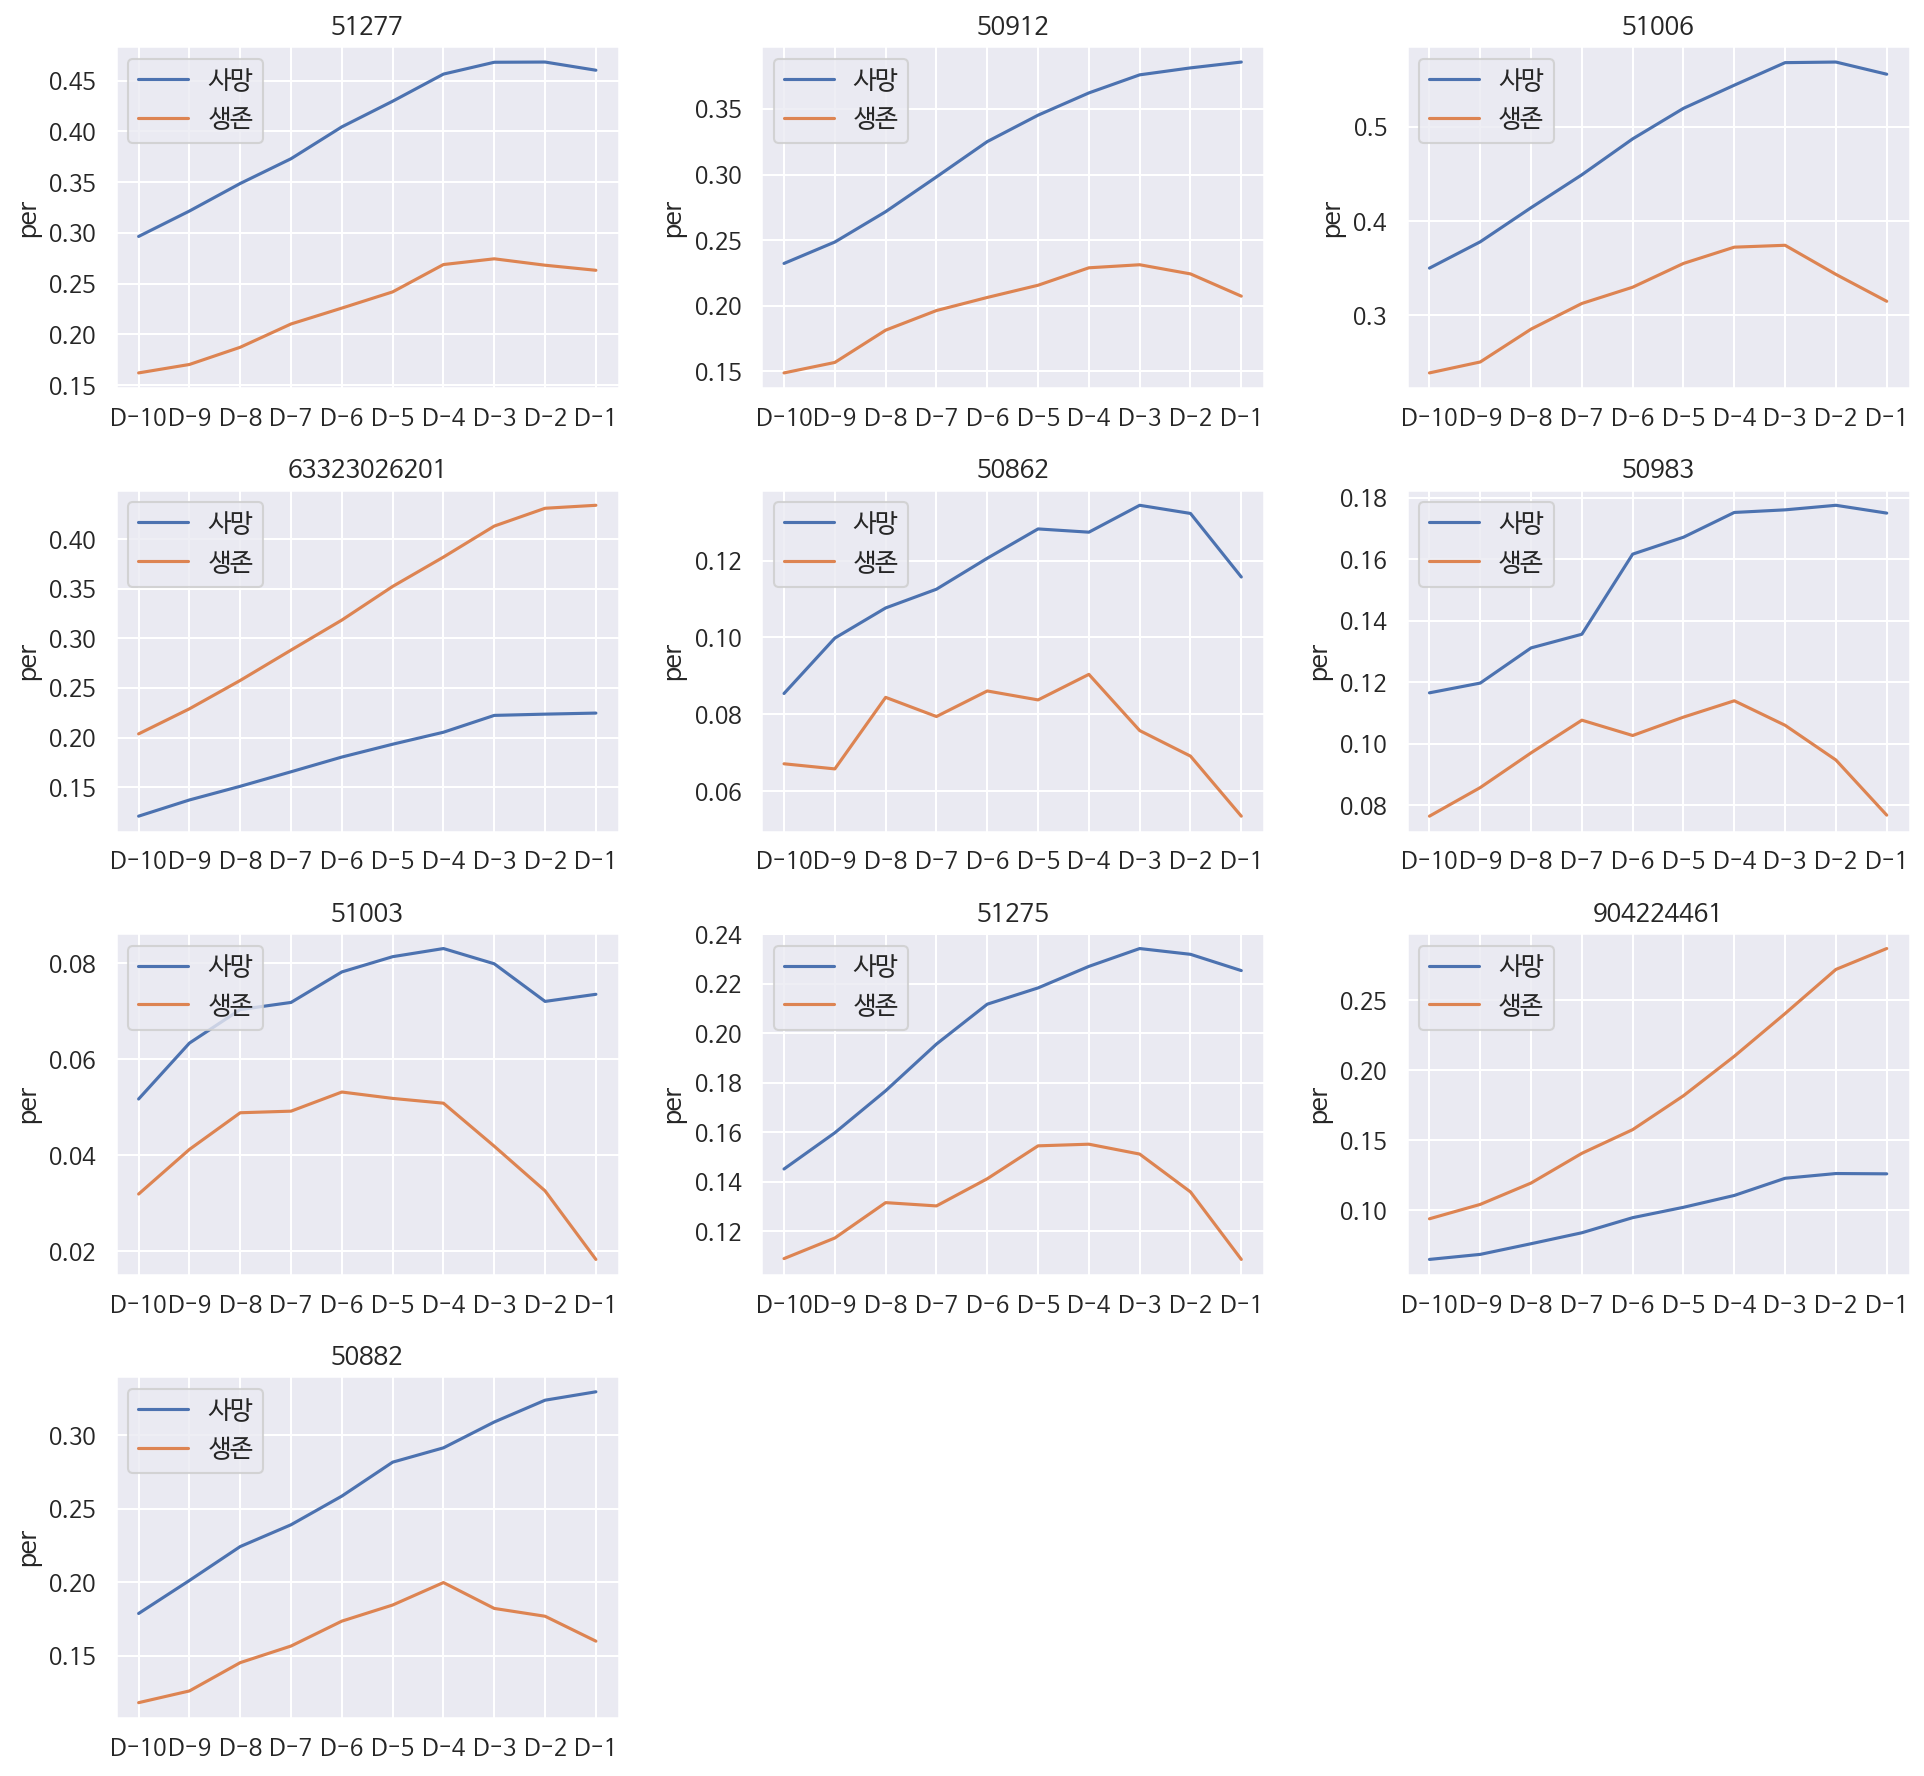

In [47]:
absum(rf_top10)

## violin plot

10it [01:10,  7.08s/it]


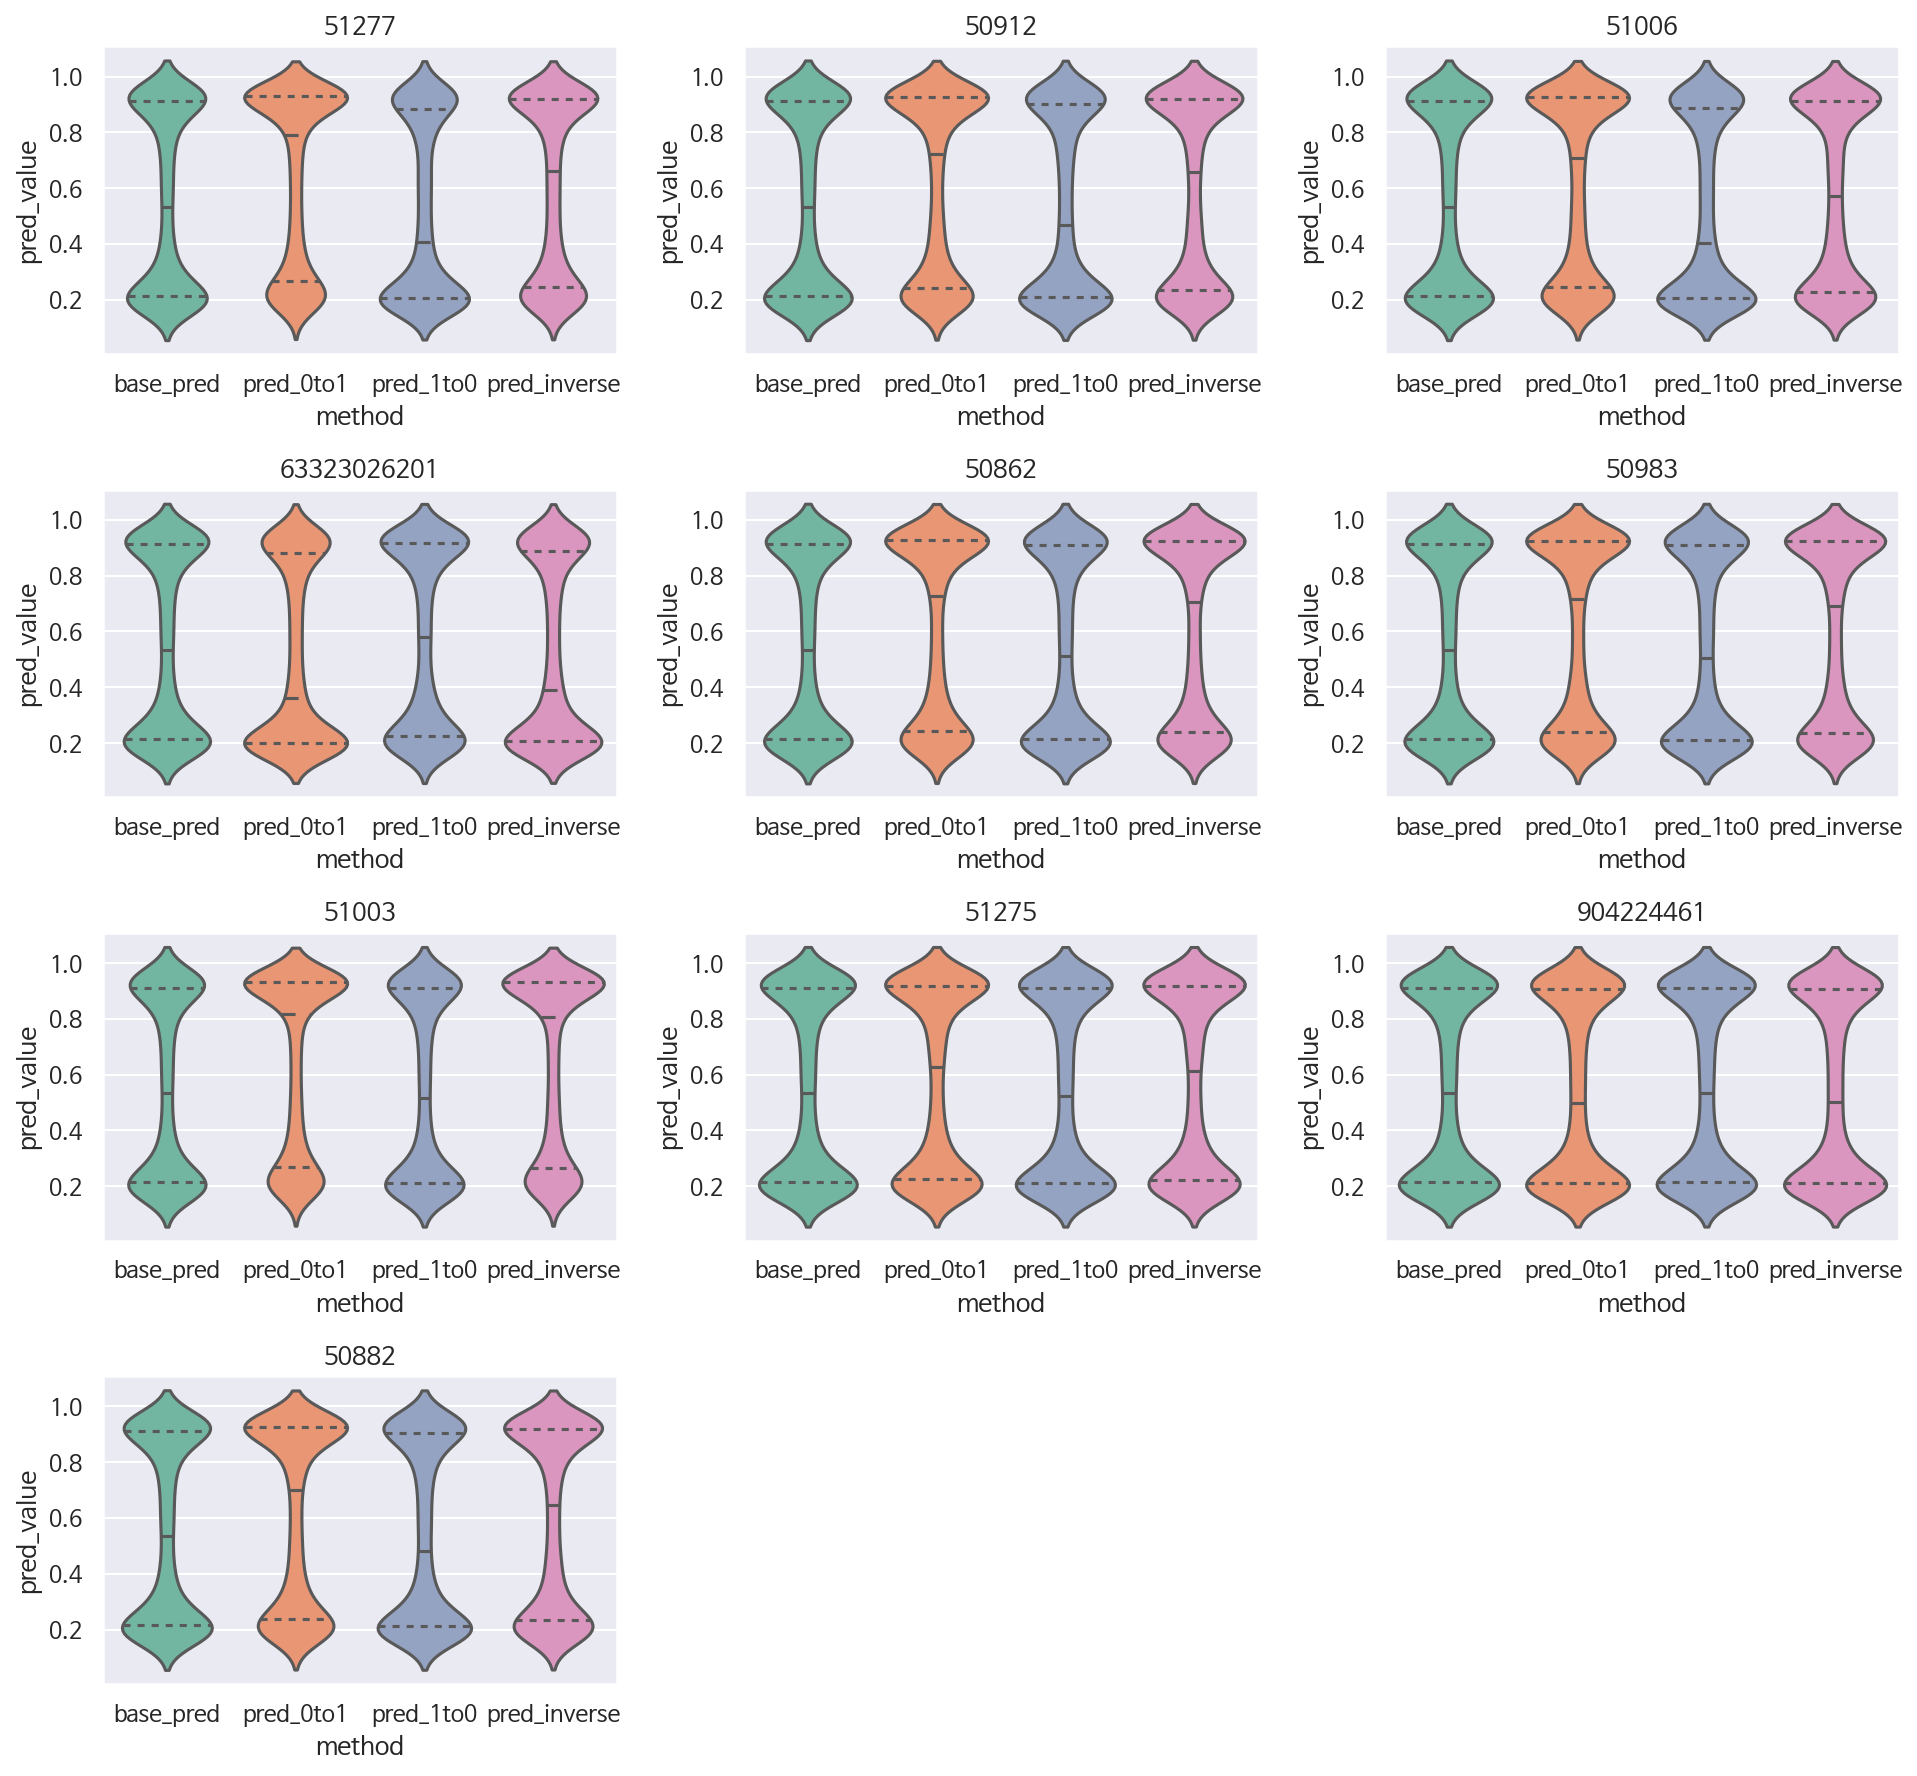

In [48]:
violin_allfit(rf_top10)